In [66]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import opendp.smartnoise.core as sn
from pyswarms.single.global_best import GlobalBestPSO
from scipy import optimize

# Benchmarking performance of 4 difference mechanichs:

## Method

In [71]:
def normal(X, rng= None):
    mu1,mu2,sigma1,sigma2 = X
    if rng == None:
        rng = np.random
    X = rng.normal(mu1, sigma1, 10_000)
    Y = rng.normal(mu2, sigma2, 10_000)
    
    out = (X+Y)/2
    
    return -mutual_info_regression(X.reshape((-1,1)), out, discrete_features=False)[0]

SigmaBounds = (0.1, 15*np.sqrt(3))
muBounds = (10,100)

## Random Search

In [46]:
def random_search(f, bounds, epochs=1000):
    best = [np.inf]
    x_s = []
    def generate_inp():
        vals = []
        for l,u in bounds:
            vals.append(np.random.uniform(l,u))
        return vals
    rng = np.random.RandomState(12345)
    for i in range(epochs):
        inp = generate_inp()
        x = f(inp, rng)
        if best[0] == np.inf:
            best[0] = x
        if best[-1] > x:
            best.append(x)
            x_s.append(inp)
    return best, x_s

In [47]:
%time x,y = random_search(normal, [muBounds, muBounds, SigmaBounds, SigmaBounds], 10_000)
print(x[-1])

CPU times: user 9min 59s, sys: 7.58 s, total: 10min 7s
Wall time: 12min 35s
-5.310648739388417


## Bayesian Optimization

CPU times: user 11min 11s, sys: 2min 6s, total: 13min 17s
Wall time: 5min 10s
Value of (x,y) that minimises the objective:[10.         41.57405937 25.98076211  0.1       ]
Minimum value of the objective: -5.596414020802194


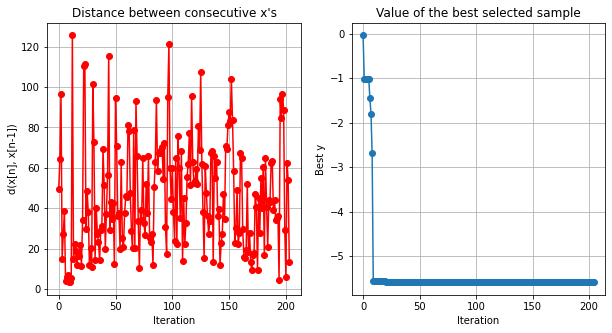

In [50]:
domain = [
    {"name": "mu_", "type": "continuous", "domain": muBounds, "dimensionality": 2},
    {"name": "std_", "type": "continuous", "domain": SigmaBounds, "dimensionality": 2}
]
rng = np.random.RandomState(12345)
f = lambda X: normal(X[0], rng)
Bopt = BayesianOptimization(f=f, domain=domain,
                         acquisition_type='EI')
%time Bopt.run_optimization(max_iter = 200, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

## Particle Swarm

In [61]:
# instatiate the optimizer
bounds = (np.asarray([10,10,0.1,0.1]), np.asarray([100,100,SigmaBounds[1],SigmaBounds[1]]))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=30, dimensions=4, options=options, bounds=bounds)

def reshaper(x):
    return [normal(xi, rng) for xi in x]

%time cost, pos = optimizer.optimize(reshaper, 1000)

2021-04-09 11:15:48,102 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-5.33
2021-04-09 11:48:17,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -5.329888539584376, best pos: [41.24335851 79.34060344 20.42069027  0.10087132]


CPU times: user 29min 19s, sys: 15.7 s, total: 29min 35s
Wall time: 32min 29s


## Nelder-Mead

In [74]:
f = lambda x: normal(x, rng)
%time optimize.minimize(f, [10,10,0.1,0.1], method="Powell", bounds=(muBounds, muBounds, SigmaBounds, SigmaBounds),options={'xtol': 0.0000001, 'ftol': 0.000001})

CPU times: user 15.2 s, sys: 62.5 ms, total: 15.2 s
Wall time: 16.1 s


   direc: array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.11298541e-01, 4.70716394e-01, 2.24932774e-01, 4.07845753e-05]])
     fun: -5.508786810205265
 message: 'Optimization terminated successfully.'
    nfev: 301
     nit: 2
  status: 0
 success: True
       x: array([32.3714061 , 87.77144953, 25.74099725,  0.10739962])